In [108]:
# Run this block to load important libraries and set things up
import torch
from torch import nn
import numpy as np
import scipy.signal
import math

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import cv2
import glob
import numpy as np
import random

# Chest X-Ray Image Classification

## Data Exploration:

For this project, the data takes the form of images, which can be manipulated a limited number of ways. To keep things simple, this project will simply ensure that images will be converted into a form that Pytorch algorithms can handle. 

### Step 1: Data Collection

The data from the Kaggle dataset is already cleaned, with "clusters of defective images are removed during the curation process and a refined dataset is obtained which is available for download." All that is left to do regarding the data is to collect it and reshape it into a way that can be processed by the SVM classifier.

This involves:
* Assigning labels
* Reading and resizing images 

It is imperative to resize the images, as processing very large images can be difficult, especially if we're treating each pixel as a feature.

#### 1A. Assigning labels
Function to return a label associated with a given path. If the path does not exist, raise an `exception`

In [109]:
def get_label_from_path(path):
    if "COVID-19" in path:
        return 0
#         return "Covid"
    elif "Normal" in path:
        return 1
#         return "Normal"
    elif "Pneumonia-Viral" in path:
        return 2
#         return "Pneumonia-Viral"
    else:
        raise Exception("Path does not contain a valid feature label: ", path)
        
def get_label_from_idx(idx):
    if idx == 0:
        return "COVID-19"
    elif idx == 1:
        return "NORMAL"
    elif idx == 2:
        return "Pneumonia-Viral"
    else:
        raise Exception("Idx does not correspond to a class")

#### 1B. Reading and Resizing Images
Function to read images from a folder given a path and resize them

In [110]:
def collect_images(path, total_features, total_labels):
    temp_files = []
    [temp_files.extend(glob.glob(path + '*.' + e)) for e in ext]
    temp_images = [cv2.imread(file) for file in temp_files]
    resized_images = []
    for image in temp_images:
        resized_images.append(cv2.resize(image, (100, 100)))
        total_labels.append(get_label_from_path(path))
    total_features.extend(resized_images)

Utilize the `collect_images` and `get_label_from_path` methods to read in images from the **Curated-dataset**.

Keep a collection of all the images and their features.

Temporarily keep a train and test split (80-20) to model a small classifier later.

In [111]:
train_paths = ["Curated-dataset/COVID-19/", "Curated-dataset/Normal/", "Curated-dataset/Pneumonia-Viral/"]
# test_paths = ["test/Covid/", "test/Normal/", "test/Viral_Pneumonia/"]
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
all_images = []
all_labels = []
print("Downloading images...")

# Collect all images from Curated-dataset
for path in train_paths:
    collect_images(path, all_images, all_labels)

# After collecting all images, randomize them
temp_arr = []
for i in range(len(all_images)):
    temp_arr.append((all_images[i], all_labels[i]))
print("Shuffling images...")

random.shuffle(temp_arr)
for i in range(len(all_images)):
    all_images[i] = temp_arr[i][0]
    all_labels[i] = temp_arr[i][1]

print("Partitioning images...")
# Temporarily keep a partition of training data and testing data
FIFTH_OF_DATA = int(0.2 * len(all_images))
train_images = all_images[: 4 * FIFTH_OF_DATA]
train_labels = all_labels[: 4 * FIFTH_OF_DATA]
test_images = all_images[4 * FIFTH_OF_DATA:]
test_labels = all_labels[4 * FIFTH_OF_DATA:]

Shuffling images...
Partitioning images...


Verify the dimensions of the data. 

In [112]:
print("Training data: ", len(train_images), len(train_labels))
print("Testing data: ", len(test_images), len(test_labels))
print("All data: ", len(all_images), len(all_labels))

Training data:  4964 4964
Testing data:  1243 1243
All data:  6207 6207


Visualize some examples of the images.

<class 'numpy.ndarray'>


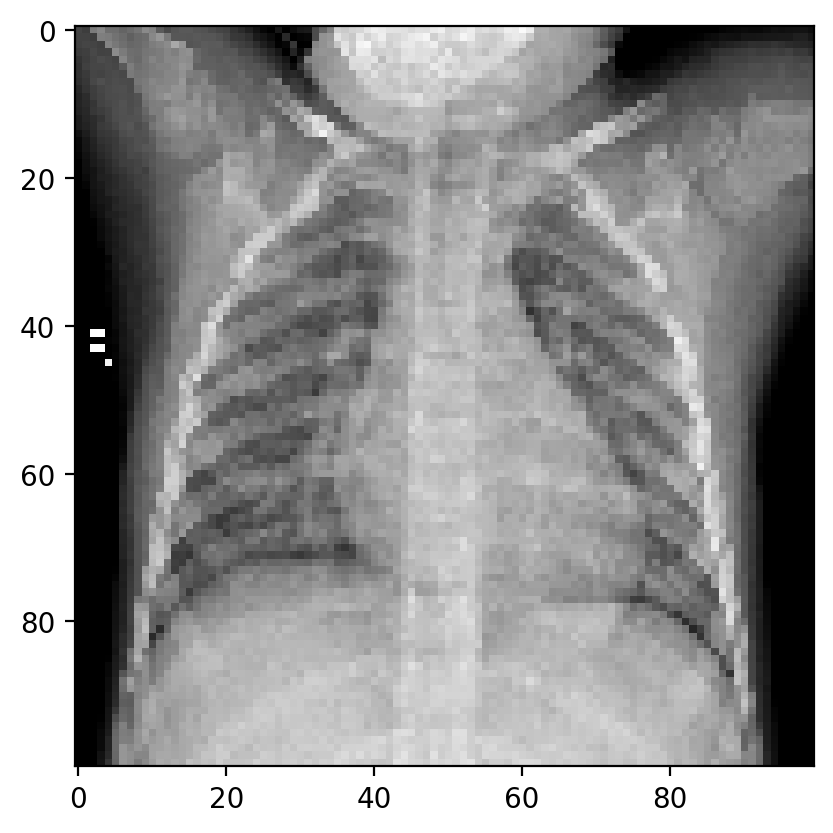

<class 'numpy.ndarray'>


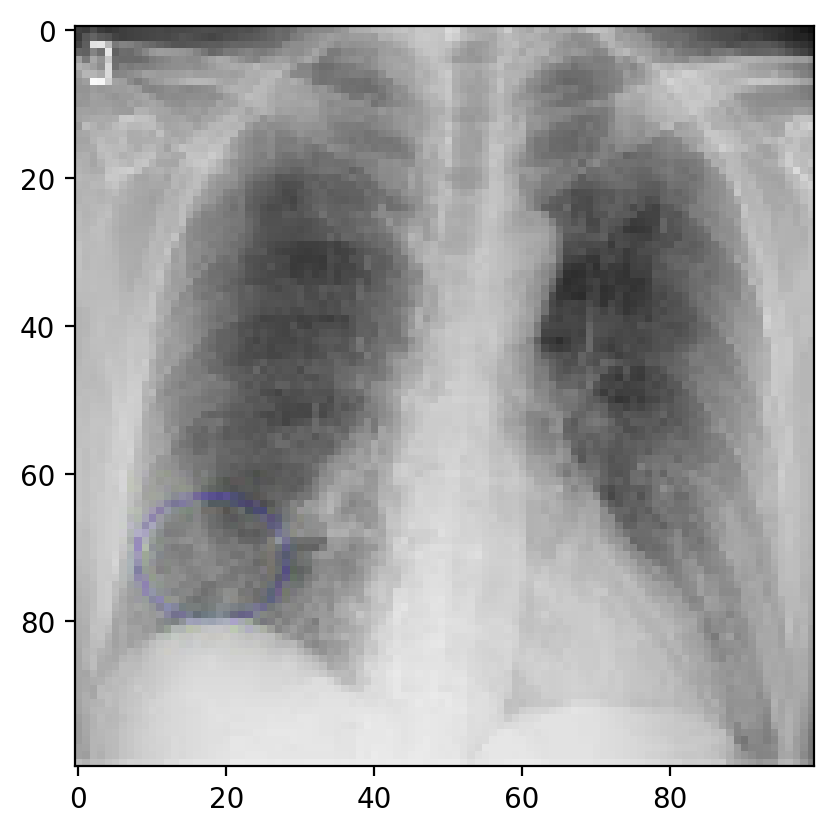

<class 'numpy.ndarray'>


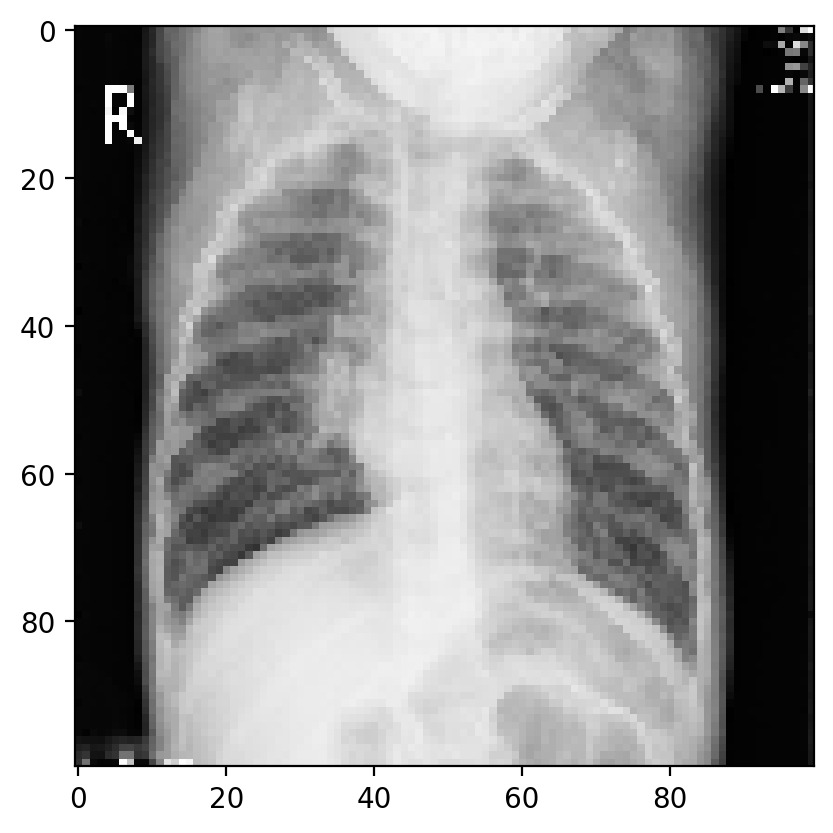

In [113]:
for i in range(3):
    random_img = random.choice(train_images)
    print(type(random_img))
    plt.imshow(random_img, interpolation='nearest')
    plt.show()

#### 1C. Flattening Images

Create a method to flatten an array of images. Apply that to `train_images`, `test_images`, and `all_images`

Function to flatten collection of 2D arrays into 1D arrays

In [186]:
def torch_inputs(inputs):
    l = []
    for i in range(len(inputs)):
        l.append(torch.permute(torch.tensor(inputs[i], dtype=torch.float32), (2, 0, 1)))
    return l
        
def torch_labels(labels):
    l = []
    for i in range(len(labels)):
        l.append(torch.tensor(labels[i], dtype=torch.long))
    return l

In [187]:
# flatten each collection of images
torch_train_images = torch_inputs(train_images)
torch_test_images = torch_inputs(test_images)
torch_all_images = torch_inputs(all_images)


torch_train_labels = torch_labels(train_labels)
torch_test_labels = torch_labels(test_labels)
torch_all_labels = torch_labels(all_labels)

print(torch_train_images[0].shape)
# print(train_images[0])
print(len(train_images))

/var/folders/gl/x526ypld1db7f5yz44ym4th40000gn/T/ipykernel_62102/1427784241.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l.append(torch.permute(torch.tensor(inputs[i], dtype=torch.float32), (2, 0, 1)))


torch.Size([3, 100, 100])
4964


/var/folders/gl/x526ypld1db7f5yz44ym4th40000gn/T/ipykernel_62102/1427784241.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l.append(torch.tensor(labels[i], dtype=torch.long))


## Model: Convolutional Neural Net

The first model to explore is the CNN classifier. Characteristics of CNN classifiers include:
* Translation invariance - moving the images left and right won't affect the accuracy
* Computationally efficient - compared to fully-connected neural networks

### Step 1: Define CNN Architecture

Create dataloaders. Since my dataset needed to be cleaned by me, I will be manually batching.

In [188]:
def batch_generator(images, labels, batch_size):
    num_samples = len(images)
    num_batches = num_samples // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]
        yield torch.stack(batch_images, dim=0), torch.stack(batch_labels, dim=0)

In [189]:
class xrayNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(3)
        )

        
    def forward(self, x):
        return self.layers(x)

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [190]:
model = xrayNN()
batch_size = 64
test_images_batches = []
test_labels_batches = []

for batch_images, batch_labels in batch_generator(torch_train_images, torch_train_labels, batch_size):
    print(batch_images.shape, batch_labels.shape)
    print(model)
    outputs = model(batch_images)
    print(outputs.shape)
    break

torch.Size([64, 3, 100, 100]) torch.Size([64])
xrayNN(
  (layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): LazyLinear(in_features=0, out_features=3, bias=True)
  )
)
torch.Size([64, 3])


/Users/allenjue/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Step 2: Train and Test Model

In [203]:
def train_network(model, torch_train_images, torch_train_labels, criterion, optimizer, nepoch=100):
    losses = []
    try:
        for epoch in range(nepoch):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for batch_images, batch_labels in batch_generator(torch_train_images, torch_train_labels, batch_size):
                optimizer.zero_grad()
                outputs = model(batch_images)
#                 print(outputs.shape)
#                 print(batch_labels.shape)
                loss = criterion(outputs, batch_labels)
                losses.append(loss.item())
#                 print(loss)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
    except KeyboardInterrupt:
        print('Exiting from training early')
    return losses

def test_network(model, torch_test_images, torch_test_labels, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for batch_images, batch_labels in batch_generator(torch_test_images, torch_test_labels, batch_size):
            outputs = model(batch_images)
             # get predicted class label for each test example.
            predicted = torch.tensor([np.argmax(output) for output in outputs])
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [204]:
model = xrayNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Using weight decay in optimizer|

In [205]:
losses = train_network(model, torch_train_images, torch_train_labels, criterion, optimizer, 10)

EPOCH 0
 Train loss: 1.42816
EPOCH 1
 Train loss: 0.20531
EPOCH 2
 Train loss: 0.15871
EPOCH 3
 Train loss: 0.13599
EPOCH 4
 Train loss: 0.12249
EPOCH 5
 Train loss: 0.11808
EPOCH 6
 Train loss: 0.08752
EPOCH 7
 Train loss: 0.07628
EPOCH 8
 Train loss: 0.07863
EPOCH 9
 Train loss: 0.09706
